# Prototype for analytical model classes

The aim of this worksheet is to experiment and design a set of classes for expressing analytical models for well test interpretation. The general idea is that there should be a parent generic class and a set of derived classes allowing to avoid repeating code.

In this first prototype, I consider only the generic parent class and two daughter classes.

Nov. 7 2019 - P. Renard

Nov. 20 2019 - N. Dutler (noflow, consthead incl. laplace)

Dec. 14 2019 - N. Dutler (Cooper-Bredehoeft-Papadopulos)

Dec. 30 2019 - N. Dutler (Report, self operator includes now all solutions and statistics from fit)

Jan. 10 2020 - N. Dutler (Jacob-Lohman, Demo Theis, change preprocessing to class)

Feb. 10 2020 - N. Dutler (GRF)

Apr. .. 2020 - N. Dutller (Argrawal time, Birsoy time, Warren&Root)

Jun. 15 2020 - N. Dutler (stehfest, dehoog, many changes related to fit function to speed up the calculations)


In [1]:
%matplotlib inline
import sys
sys.path.append("..")
import openhytest as ht
import mpmath as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.special import factorial

In [2]:
# Read a data set to test ideas
df1 = pd.read_csv('../data/ths_ds1.txt', header=None,sep=" ",names=['t','s'], dtype={'t': 'float64', 's': 'float64'})
df2 = pd.read_csv('../data/thn_ds1.txt', header=None,sep=" ",names=['t','s'], dtype={'t': 'float64', 's': 'float64'})
df3 = pd.read_csv('../data/thc_ds1.txt', header=None,sep=" ",names=['t','s'], dtype={'t': 'float64', 's': 'float64'})
df4 = pd.read_csv('../data/pca_ds1.txt', header=None,sep=" ",names=['t','s'], dtype={'t': 'float64', 's': 'float64'})
df5 = pd.read_csv('../data/jlq_ds1.txt', header=None,sep=" ",names=['t','q'], dtype={'t': 'float64', 'q': 'float64'})
df6 = pd.read_csv('../data/tmc_ds1.txt', header=None,sep="  ",names=['t','q'], dtype={'t': 'float64', 'q': 'float64'})
df7 = pd.read_csv('../data/tmr_ds1.txt', header=None,sep=" ",names=['t','s'], dtype={'t': 'float64', 's': 'float64'})

/Users/nathan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


Below is the part where the classes are defined in order to test the concept.

The first thing is to define a generic class AnalyticalModels of analytical models that should contain all the generic functionalities.  Then, we derive two examples of daughter classes: the theis and theis_noflow models. 

The theis_noflow model is wrong (wrong equations and parametrizations and needs to be corrected), but the principle seems to work.

The next steps would be to implement:
- the fit function
- one or a pair of examples with laplace domain solution


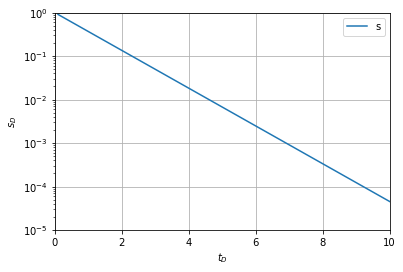

In [3]:
slug = ht.Hvorslev()
slug.plot_typecurve()

# How to create a type curve

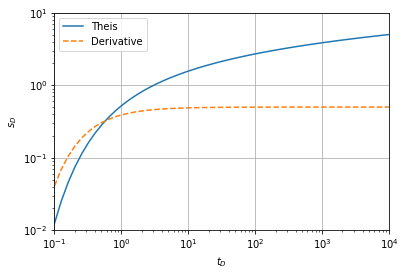

In [11]:
abaque = ht.Theis()
abaque.plot_typecurve()

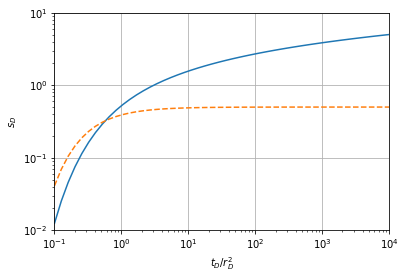

In [12]:
td = np.logspace(-1, 4)
abaque.fitcoeff = 12
abaque._coeff()
sd = abaque._laplace_drawdown(td, inversion_option='stehfest')
sd4 = abaque._laplace_drawdown(td, inversion_option='dehoog')
plt.loglog(td, sd)
#dev = ht.ldiffs(pd.DataFrame({'td':td, 'sd':sd}))
dd = abaque._laplace_drawdown_derivative(td, inversion_option='stehfest')
dd4 = abaque._laplace_drawdown_derivative(td, inversion_option='dehoog')
plt.xlabel('$t_D / r_D^2$')
plt.ylabel('$s_D$')
plt.plot(td,dd, '--')
plt.xlim((1e-1, 1e4))
plt.ylim((1e-2, 1e1))
plt.grid('True')

In [13]:
#Stehfest check
M = np.int(12)
V = np.zeros(M)
for i in range(1,M+1):
    vi = 0
    for k in range(np.int((i+1)/2),np.int(np.min([i,M/2]))+1):
        vi = vi + (k**(M/2)*factorial(2*k))/(factorial(np.int(M/2-k))*factorial(k)*factorial(k-1)*factorial(i-k)*factorial(2*k-i))
    V[i-1] = (-1) ** ((M/2)+i)*vi
print(V)

[-1.66666667e-02  1.60166667e+01 -1.24700000e+03  2.75543333e+04
 -2.63280833e+05  1.32413870e+06 -3.89170553e+06  7.05328633e+06
 -8.00533650e+06  5.55283050e+06 -2.15550720e+06  3.59251200e+05]


In [14]:
p = np.zeros([M, np.size(td)])
for i in range(1,M+1):
    p[i-1] = i*np.log(2)/td
uu = abaque.dimensionless_laplace(p)
VV = np.repeat(V, np.size(td)).reshape(M,np.size(td))
su = np.multiply(VV, uu)
s = np.log(2)/td*sum(su)
print(s)

[0.0124716  0.0252832  0.04560463 0.07490487 0.11406451 0.16333642
 0.22243057 0.2906622  0.36710941 0.45074749 0.54054765 0.63554072
 0.73485238 0.83771798 0.94348392 1.05160116 1.1616146  1.27315084
 1.38590599 1.49963427 1.61413785 1.72925813 1.84486833 1.96086733
 2.07717465 2.19372629 2.31047148 2.42736991 2.54438963 2.66150534
 2.77869699 2.89594871 3.01324795 3.13058478 3.24795132 3.36534137
 3.48275001 3.60017334 3.71760829 3.83505242 3.95250383 4.06996097
 4.18742265 4.30488793 4.42235604 4.5398264  4.65729853 4.77477207
 4.89224671 5.00972223]


In [15]:
sd2 = abaque.dimensionless(td)
residual = sd-sd2

mr = np.mean(residual) #mean resiudal
print(mr)
sr = 2 * np.std(residual) #standard deviation
print(sr)
rms = np.sqrt(np.mean(residual**2))
print(rms)

4.1250783462447314e-07
1.304343888134819e-05
6.534752265885295e-06


In [16]:
dd2 = abaque.dimensionless_logderivative(td)
residual2 = dd-dd2

mr2 = np.mean(residual2) #mean resiudal
print(mr2)
sr2 = 2 * np.std(residual2) #standard deviation
print(sr2)
rms2 = np.sqrt(np.mean(residual2**2))
print(rms2)

-4.614045341219675e-07
3.5574257625101375e-05
1.7793112306125063e-05


In [17]:
#dehoog check
alpha = 0
tol = 1e-9
M = 20 
logallt = np.log10(td)
iminlogallt = np.floor(np.min(logallt))
imaxlogallt = np.ceil(np.max(logallt))
f = []
for ilogt in range(np.int(iminlogallt), np.int(imaxlogallt)+1):
    t = td[((logallt>=ilogt) & (logallt<(ilogt+1)))]
    if t is not None:
        T = 2 * np.max(t)
        gamma = alpha - np.log(tol) / (2*T)
        run = np.linspace(0,2*M, 2*M+1)
        p = gamma + 1j * np.pi * run / T    
        a = abaque.dimensionless_laplace(p)#Fp(p);      # evaluate function
        a[0] = a[0] / 2 # zero term is halved
        # build up e and q tables.
        e = np.zeros((2*M+1, M+1), dtype=complex)
        q = np.zeros((2*M, M+1), dtype=complex)
        q[:,1] = a[1:2*M+1]/a[0:2*M]
        for r in np.arange(1,M+1):
            e[0:2*(M-r)+1,r] = q[1:2*(M-r)+2,r] - q[0:2*(M-r)+1,r] + e[1:2*(M-r)+2,r-1]
            if r < M:
                rq = r + 1
                q[0:2*(M-rq)+2,rq] = q[1:2*(M-rq)+3,rq-1]*e[1:2*(M-rq)+3,rq-1]/e[0:2*(M-rq)+2,rq-1]
        # build up d vector  
        d = np.zeros((2*M+1,1), dtype=complex)
        d[0] = a[0]
        d[1:2*M:2] = np.vstack(-q[0,1:M+1])
        d[2:2*M+1:2] = np.vstack(-e[0,1:M+1])
        # build up A and B matrix
        A = np.zeros((2*M+2,len(t)), dtype=complex)
        B = np.zeros((2*M+2,len(t)), dtype=complex)
        A[1,:] = d[0,0]*np.ones((1,len(t)))
        B[0,:] = np.ones((1,len(t)))
        B[1,:] = np.ones((1,len(t)))
        z = np.exp(1j*np.pi*t/T)
        for n in np.arange(2, 2*M+2):
            A[n,:] = A[n-1,:] + d[n-1]*np.ones((1,len(t)))*z*A[n-2,:]
            B[n,:] = B[n-1,:] + d[n-1]*np.ones((1,len(t)))*z*B[n-2,:]
            
        h2M = .5 * ( np.ones((1,len(t))) + ( d[2*M-1]-d[2*M] ) * np.ones((1,len(t))) * z )
        R2Mz = -h2M*(np.ones((1,len(t))) - (np.ones((1,len(t))) + d[2*M]*np.ones((1,len(t))) * z / h2M ** 2) ** 5)
        A[2*M+1,:] = A[2*M,:] + R2Mz * A[2*M-1,:]
        B[2*M+1,:] = B[2*M,:] + R2Mz * B[2*M-1,:]
        fpiece = np.array(1/T * np.exp(gamma * t) * np.real(A[2*M+1,:] / B[2*M+1,:]))
        f = np.append(f, np.hstack(fpiece))
print(f)

[0.01245744 0.02525918 0.04558469 0.07489876 0.11407285 0.16335314
 0.22244812 0.2906754  0.36711652 0.4507493  0.5405459  0.63553769
 0.7348491  0.83771523 0.94348191 1.05159985 1.16161382 1.2731504
 1.38590576 1.49963413 1.61413754 1.72925807 1.84486821 1.9608672
 2.07717449 2.19372613 2.31047131 2.42736973 2.54438944 2.66150515
 2.77869675 2.89594853 3.01324776 3.13058459 3.24795113 3.36534118
 3.48274982 3.60017315 3.71760809 3.83505223 3.95250358 4.06996078
 4.18742246 4.30488774 4.42235585 4.53982621 4.65729834 4.77477188
 4.89224652 5.00972204]


In [18]:
residual = sd4-sd2

mr = np.mean(residual) #mean resiudal
print(mr)
sr = 2 * np.std(residual) #standard deviation
print(sr)
rms = np.sqrt(np.mean(residual**2))
print(rms)

residual2 = dd4-dd2

mr2 = np.mean(residual2) #mean resiudal
print(mr2)
sr2 = 2 * np.std(residual2) #standard deviation
print(sr2)
rms2 = np.sqrt(np.mean(residual2**2))
print(rms2)

-1.6597490232446443e-06
2.2931115024609566e-05
1.1585066934987047e-05
5.356356947941454e-08
1.2809075426664418e-06
6.426897301111336e-07


# How to adjust a Theis model using guess_params and the fit function

estimated parameter vector: [  1.70038569 341.82452507]


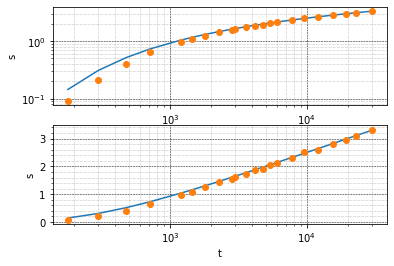

T =  0.0014965736386863039 m2/s
S =  1.838230592225941e-05 -
Ri =  3125.64516579519 m


In [19]:
apaque= ht.Theis(Q=1.3888e-2, r=250, df=df1)
p = apaque.guess_params()
print("estimated parameter vector:",p)
apaque.trial()

`ftol` termination condition is satisfied.
Function evaluations 13, initial cost 3.2141e-02, final cost 8.4643e-03, first-order optimality 2.18e-10.
[  1.78563637 412.12162662]


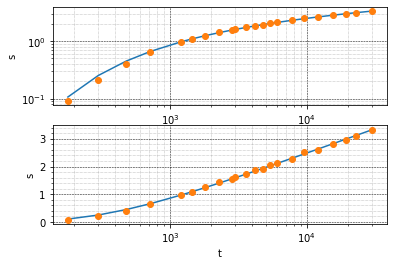

T =  0.0014251235274012491 m2/s
S =  2.1104574206023773e-05 -
Ri =  2846.613998659661 m


In [20]:
p = apaque.fit(fitmethod='lm')
print(p)
apaque.trial()

`ftol` termination condition is satisfied.
Function evaluations 4, initial cost 8.4643e-03, final cost 8.4643e-03, first-order optimality 7.37e-10.


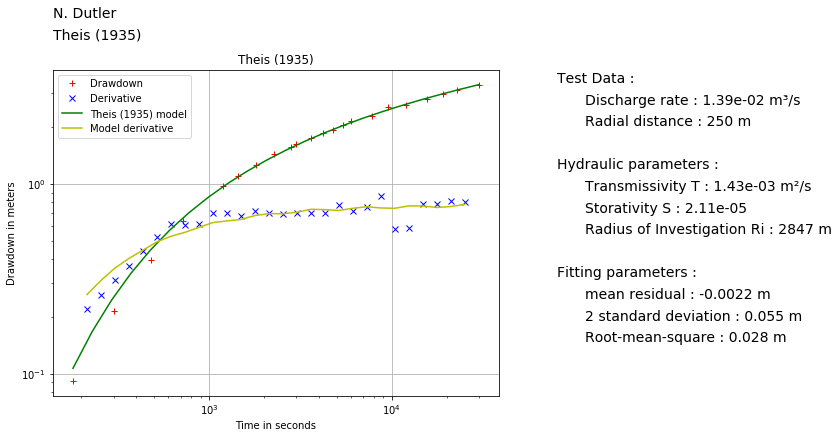

In [21]:
apaque.rpt(author='N. Dutler', filetype='png')

# Moving to no flow model

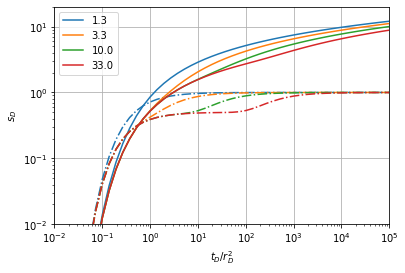

In [22]:
model = ht.Theis_noflow(Rd=33)
model.plot_typecurve()

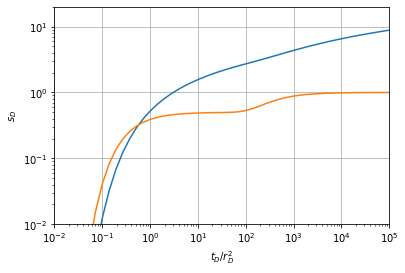

In [23]:
td = np.logspace(-2, 5)
sd = model._laplace_drawdown(td, inversion_option='dehoog')
plt.loglog(td, sd)
dd = model._laplace_drawdown_derivative(td, inversion_option='dehoog')
plt.loglog(td, dd)
plt.xlabel('$t_D / r_D^2$')
plt.ylabel('$s_D$')
plt.xlim((1e-2, 1e5))
plt.ylim((1e-2, 20))
plt.grid('True')

In [24]:
sd2 = model.dimensionless(td)
residual = sd-sd2

mr = np.mean(residual) #mean resiudal
print(mr)
sr = 2 * np.std(residual) #standard deviation
print(sr)
rms = np.sqrt(np.mean(residual**2))
print(rms)

6.813733133585937e-09
3.1270010391611e-08
1.7055214647977662e-08


In [25]:
dd2 = model.dimensionless_logderivative(td)
residual2 = dd-dd2

mr2 = np.mean(residual2) #mean resiudal
print(mr2)
sr2 = 2 * np.std(residual2) #standard deviation
print(sr2)
rms2 = np.sqrt(np.mean(residual2**2))
print(rms2)

3.224417621801552e-09
2.866840105477321e-08
1.4692384890109392e-08


estimated parameter vector: [2.08083534e+00 4.09480142e+02 5.31857688e+04]


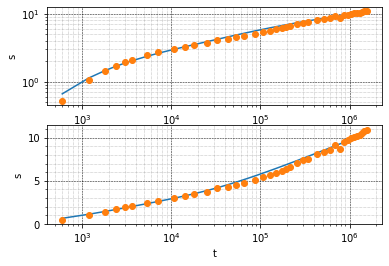

T =  0.0011623637059593906 m2/s
S =  0.002672351562304948 -
Ri =  227.9351449908511 m


In [26]:
model = ht.Theis_noflow(Q=0.0132,r=20, df=df2)
p = model.guess_params()
print("estimated parameter vector:",p)
model.trial()


In [27]:
p = model.fit(fitmethod='trf')
p

`ftol` termination condition is satisfied.
Function evaluations 14, initial cost 1.7005e+00, final cost 7.4091e-01, first-order optimality 1.14e-07.


array([2.45693472e+00, 7.00752725e+02, 1.73583851e+05])

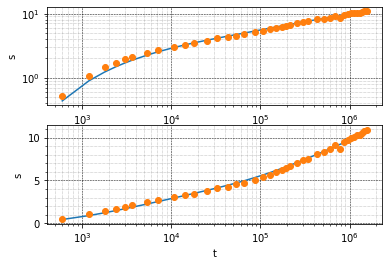

T =  0.000984432940969301 m2/s
S =  0.003873197458910458 -
Ri =  314.77646742004 m


In [28]:
model.trial()

`gtol` termination condition is satisfied.
Function evaluations 3, initial cost 7.4091e-01, final cost 7.4091e-01, first-order optimality 4.78e-09.


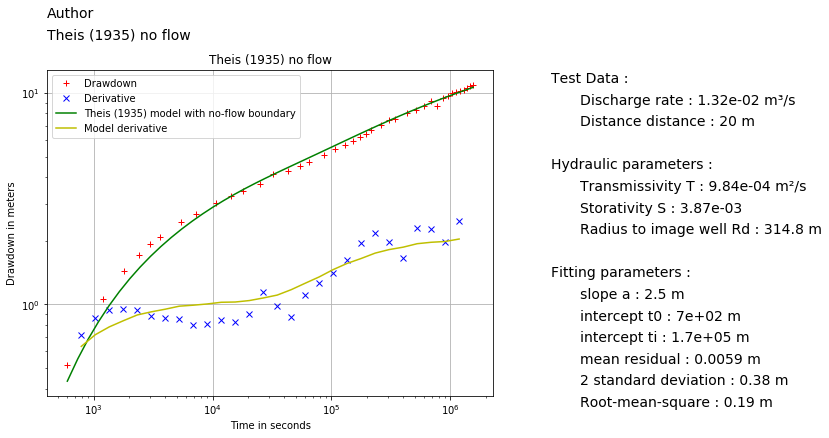

In [29]:
model.rpt(fitmethod='trf')

# Moving to constant head model

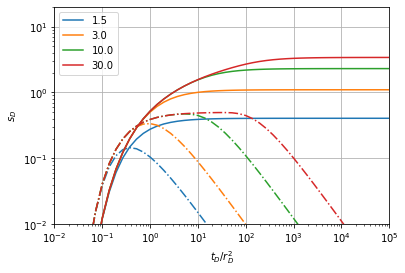

In [30]:
bequer = ht.Theis_constanthead(Rd=33)
bequer.plot_typecurve()

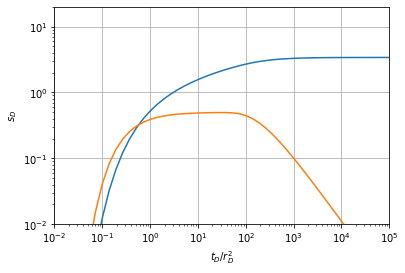

In [31]:
td = np.logspace(-2, 5)
sdn = bequer._laplace_drawdown(td, inversion_option='dehoog')
sd = list(sdn)
plt.loglog(td, sd)
ddn = bequer._laplace_drawdown_derivative(td, inversion_option='dehoog')
dd = list(ddn)
plt.loglog(td, dd)
plt.xlabel('$t_D / r_D^2$')
plt.ylabel('$s_D$')
plt.xlim((1e-2, 1e5))
plt.ylim((1e-2, 20))
plt.grid('True')

In [32]:
sd2 = bequer.dimensionless(td)
residual = sd-sd2

mr = np.mean(residual) #mean resiudal
print(mr)
sr = 2 * np.std(residual) #standard deviation
print(sr)
rms = np.sqrt(np.mean(residual**2))
print(rms)

7.266485093952918e-09
1.137599753953202e-07
5.7342260211004975e-08


In [33]:
dd2 = bequer.dimensionless_logderivative(td)
residual2 = dd-dd2

mr2 = np.mean(residual2) #mean resiudal
print(mr2)
sr2 = 2 * np.std(residual2) #standard deviation
print(sr2)
rms2 = np.sqrt(np.mean(residual2**2))
print(rms2)

1.077177535427073e-09
8.214835056527988e-09
4.24631489580307e-09


estimated parameter vector: [6.22576096e-01 4.76664633e+01 7.62562843e+04]


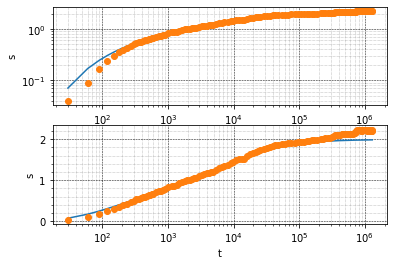

T =  0.008829470041817375 m2/s
S =  0.0023630138786012293 -
Ri =  799.9472518866424 m


In [34]:
bequer = ht.Theis_constanthead(Q=0.030,r=20, df=df3)
p = bequer.guess_params()
print("estimated parameter vector:",p)
bequer.trial()

In [36]:
p = bequer.fit(fitmethod='trf')

`ftol` termination condition is satisfied.
Function evaluations 8, initial cost 1.0579e+00, final cost 9.9037e-02, first-order optimality 6.68e-08.


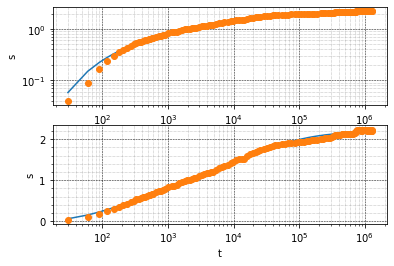

T =  0.008702275255660532 m2/s
S =  0.002656954994692496 -
Ri =  1104.6668793834237 m


In [37]:
bequer.trial()

`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 9.9037e-02, final cost 9.9037e-02, first-order optimality 1.15e-09.


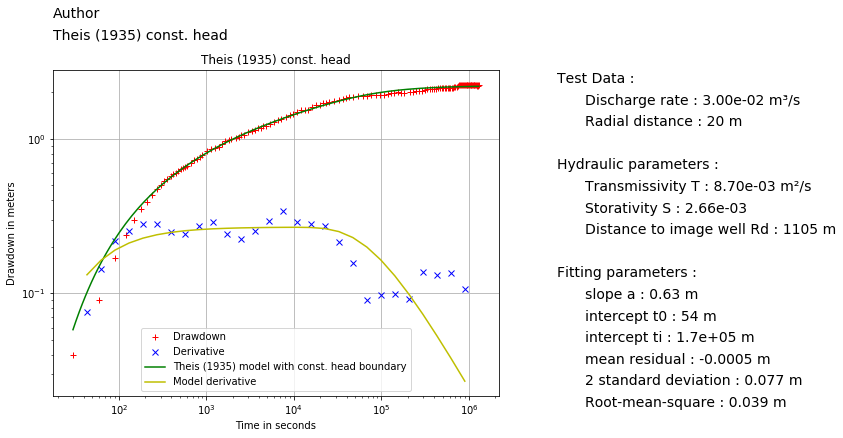

In [38]:
bequer.rpt()

# Cooper-Bredehoeft-Papadopulos (1967) model

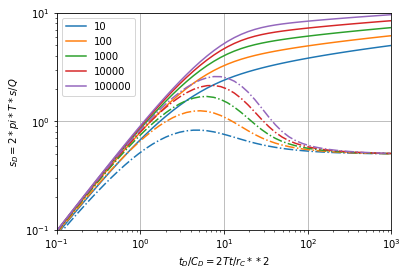

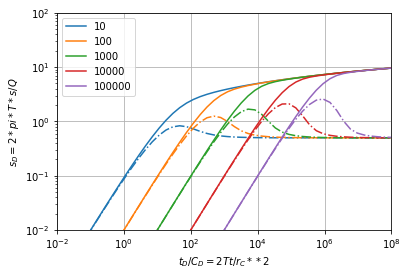

In [39]:
coobredpapa = ht.PapadopulosCooper(r=1, rc=1)
coobredpapa.plot_typecurve()

In [51]:
coo= ht.PapadopulosCooper(Q=0.0050472, r=3.048, rw=0.6096, rc=0.6096, df=df4)  
p = coo.guess_params()
coo.inversion_option = 'dehoog'
print("estimated parameter vector:",p)

estimated parameter vector: [ 1.12133498 12.07038587]


Exception: Data must be 1-dimensional

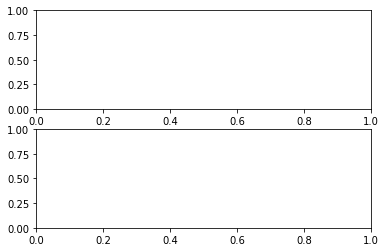

In [52]:
coo.trial()

In [53]:
coo.rpt()

../openhytest/modelclasses.py:297: RuntimeWarning: invalid value encountered in log10
  logallt = np.log10(td)
../openhytest/modelclasses.py:298: RuntimeWarning: All-NaN slice encountered
  iminlogall = np.int(np.floor(np.nanmin(logallt)))


ValueError: cannot convert float NaN to integer

In [54]:
coobredpapa= ht.CooperBredehoeftPapadopulos(Q=0.0050472, r=3.048, rw=0.6096, rc=0.6096, cD=50, df=df4)  
coobredpapa.guess_params()
coobredpapa.rpt()

AttributeError: module 'openhytest' has no attribute 'CooperBredehoeftPapadopulos'

# Jacob-Lohman (1952) model

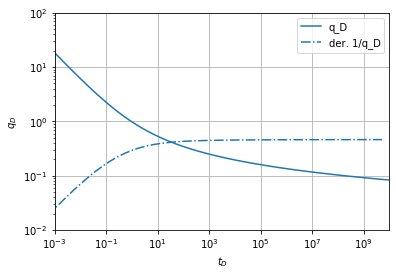

../openhytest/modelclasses.py:1670: RuntimeWarning: divide by zero encountered in true_divide
  q2 = 2 / E1(1, 0.25 / td)
/Users/nathan/opt/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:6759: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/Users/nathan/opt/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:6759: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/Users/nathan/opt/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:6759: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/Users/nathan/opt/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:6759: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


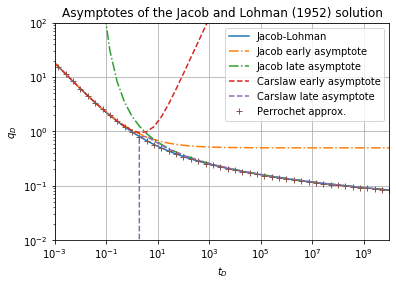

Mean residual between Jacob-Lohman and Perrochet approx.  0.0020691929377569347 m^3/s
Standard deviation  0.0026500176939713584 m^3/s
Root-mean-square  0.002457073026642369 m^3/s


In [55]:
jcl = ht.JacobLohman(s=28.142, r=0.084, df = df5)
jcl.plot_typecurve()

In [56]:
jcl.guess_params()

array([4.29069293e+02, 2.44768687e-04])

`xtol` termination condition is satisfied.
Function evaluations 37, initial cost 2.4820e-09, final cost 1.4232e-09, first-order optimality 2.45e-06.


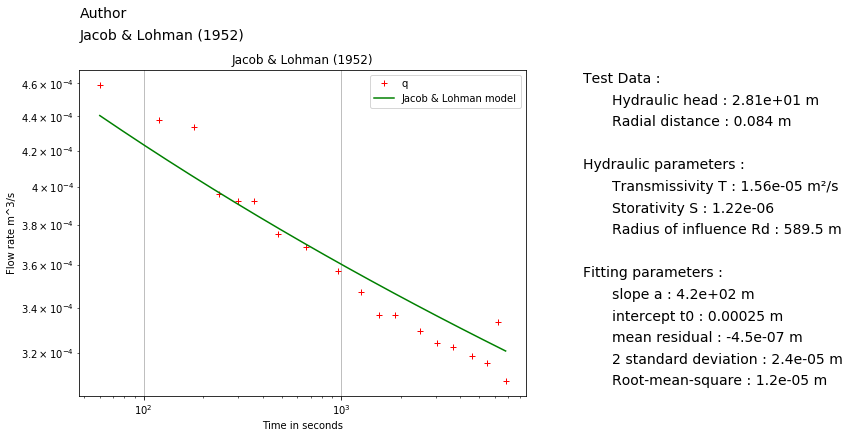

In [57]:
jcl.fitcoeff = 16
jcl.rpt()

[[1800, 0.005787037037037038], [4800, 0.008101851851851851], [7800, 0.006944444444444444]]


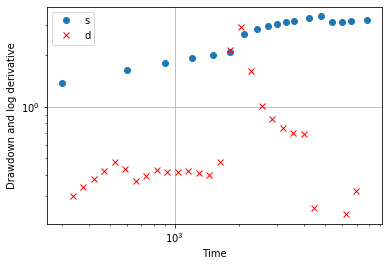

In [58]:
Qmat = [[30*60, 500/3600/24], 
        [80*60, 700/3600/24], 
        [130*60, 600/3600/24]]
print(Qmat)
pro=ht.preprocessing(df=df7, Qmat=Qmat)
pro.diagnostic()
aba = ht.Theis(df=df7)

In [59]:
aba.guess_params()

array([0.57362543, 0.01436084])

## GRF Barker (1988)

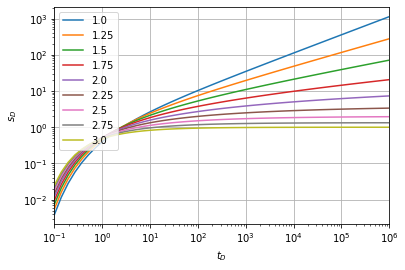

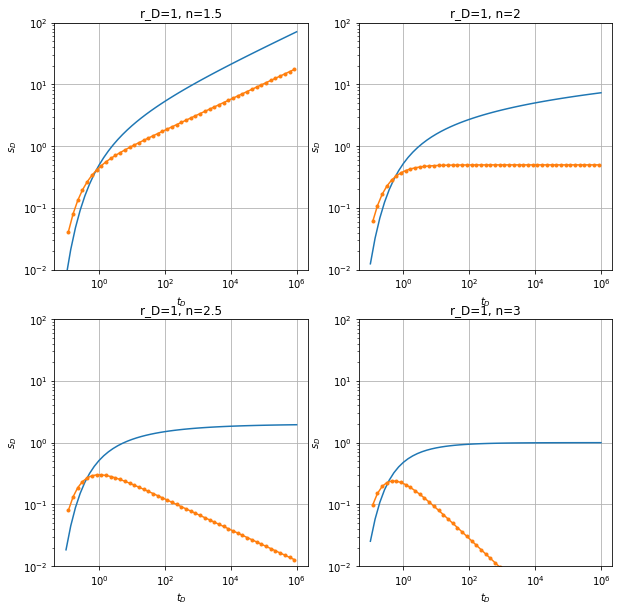

In [60]:
genrad = ht.GRF()
genrad.plot_typecurve()